# Assess the Output of a Saved Model

This notebook allows you to load the weights of a trained U-Net model, pass data to it, and turn the model's output back in to audio, for subjective assesment against the original mixed and isolated signals.

In [1]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf

import Audio_functions as af
import UNet
import Dataset

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Get the variables and data ready

In [1]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=True
batch_size = 5
shuffle=False
n_shuffle = 1

checkpoint = '43/43-1001'
model_base_dir = 'C:/Users/Toby/MSc_Project/MScFinalProjectCheckpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

#directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Voice/train-clean-100/19/198/'

#  Create the pipeline
tf.reset_default_graph()
data = Dataset.zip_files(directory_a, directory_b)
data = Dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

#  Create the iterator
mixed_spec, voice_spec, mixed_audio, voice_audio = data.make_one_shot_iterator().get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 0], 3)

NameError: name 'tf' is not defined

In [278]:
data

<PrefetchDataset shapes: ((?, 256, 513, 2), (?, 256, 513, 2), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

### Define the model structure

In [85]:
# Build U-Net model
print('Creating model')
model = UNet.UNetModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, voice_audio, 'unet', is_training, name='U_Net_Model')
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Creating model


### Load the saved weights - Skip this cell to hear results from a randomly initialised network

In [86]:

print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from C:/Users/Toby/MSc_Project/MScFinalProjectCheckpoints\43/43-1001


### Run a batch

In [87]:
mix_mag, mix_phase, voice_mag, voice_est_mag, mask, voice_wave, mix_wave = sess.run([model.mixed_mag, 
                                                                                     model.mixed_phase, 
                                                                                     model.voice_mag,
                                                                                     model.gen_voice, 
                                                                                     model.voice_mask, 
                                                                                     model.voice_audio, 
                                                                                     model.mixed_audio],
                                                                                    {model.is_training:False})
voice_est_wave = list()

for i in range(voice_mag.shape[0]):
    voice_est_wave.append(af.spectrogramToAudioFile(np.squeeze(voice_est_mag[i, :, :, :]).T, n_fft,
                                                    fft_hop, phaseIterations=0, phase=np.squeeze(mix_phase[i, :, :, :]).T))


### Listen to the output

The output will consist of up to [batch_size] clips from a single recording.

In [254]:
len(voice_est_wave)

5

In [255]:
#  The original mixture
ipd.Audio(mix_wave[1].T, rate=sample_rate)

In [256]:
#  The original isolated voice
ipd.Audio(voice_wave[1].T, rate=sample_rate)

In [257]:
#  The estimated isolated voice produced by the network
ipd.Audio(voice_est_wave[1], rate=sample_rate)

In [20]:
len(voice_est_wave[0])

65280

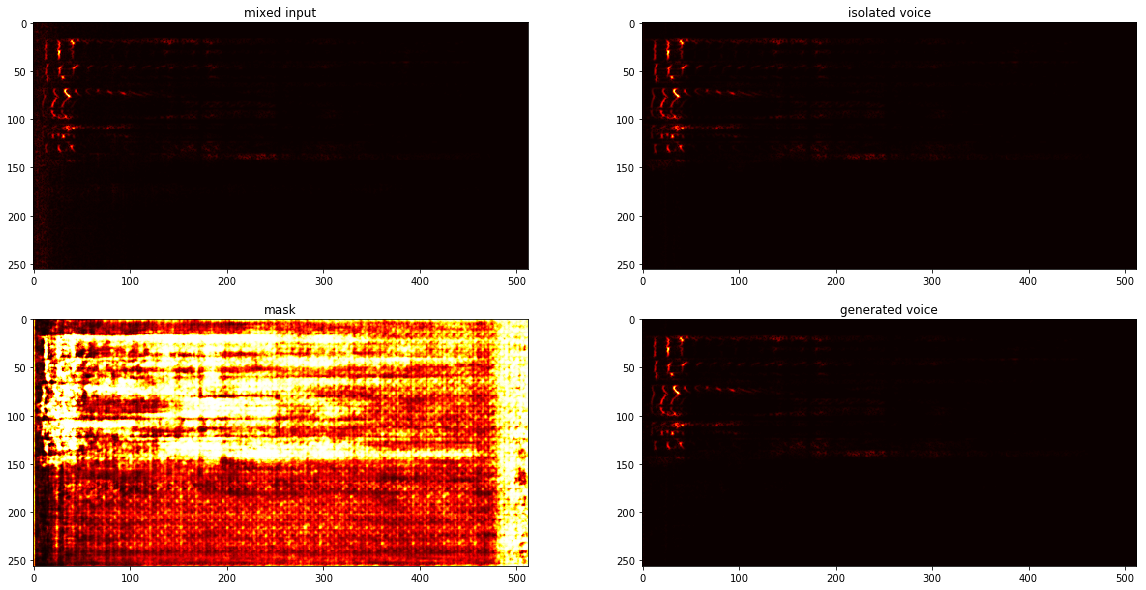

In [263]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mix_mag[0,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice_mag[0,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[0,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(voice_est_mag[0,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

# Reconstruction Investigation

In [89]:
import matplotlib.pyplot as plt
import mir_eval

In [93]:
x = range(1000)

In [90]:
x = range(voice_wave[1].shape[0])
metrics = {}
metrics['mix'] = mir_eval.separation.bss_eval_sources(voice_wave[1].T, mix_wave[1].T, compute_permutation=False)
metrics['voice'] = mir_eval.separation.bss_eval_sources(voice_wave[1].T, voice_wave[1].T, compute_permutation=False)
metrics['voice_est'] = mir_eval.separation.bss_eval_sources(voice_wave[1].T, voice_est_wave[1].T, compute_permutation=False)
metrics['sim_noise'] = mir_eval.separation.bss_eval_sources(voice_wave[1].T, noisy_wave.T, compute_permutation=False)

C:\Program Files\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


NameError: name 'noisy_wave' is not defined

(array([11.49663594]), array([inf]), array([11.49663594]), array([0]))


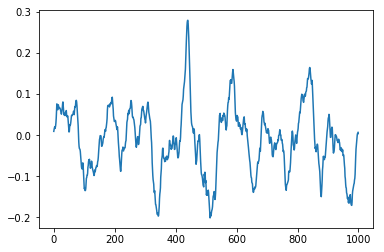

In [94]:
#  The original mixture
print(metrics['mix'])
plt.plot(x,mix_wave[0][0:1000])
ipd.Audio(mix_wave[0].T, rate=sample_rate)

(array([260.81387181]), array([inf]), array([260.81387181]), array([0]))


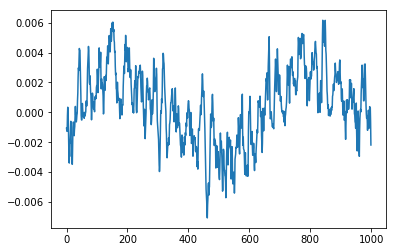

In [96]:
#  The original isolated voice
print(metrics['voice'])
plt.plot(x,voice_wave[0][0:1000])
ipd.Audio(voice_wave[0].T, rate=sample_rate)

(array([14.72983745]), array([inf]), array([14.72983745]), array([0]))


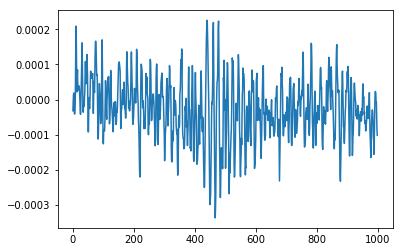

In [97]:
#  The estimated isolated voice produced by the network
print(metrics['voice_est'])
plt.plot(x,voice_est_wave[0][0:1000])
ipd.Audio(voice_est_wave[0], rate=sample_rate)

(array([13.71047621]), array([inf]), array([13.71047621]), array([0]))


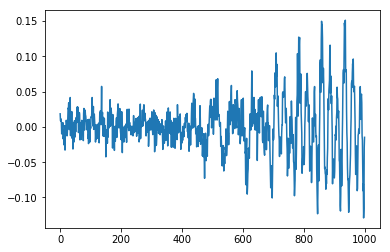

In [297]:
# Original voice with added Gaussian noise
noise = np.expand_dims(np.random.normal(scale=0.01, size=voice_wave[1].shape[0]),1)
noisy_wave = voice_wave[3] + noise
print(metrics['sim_noise'])
plt.plot(x,noisy_wave[0:1000])
ipd.Audio(noisy_wave.T, rate=sample_rate)

In [180]:
voice_spect = af.compute_spectrogram(voice_wave[1], n_fft, fft_hop, normalise=True)

In [181]:
voice_spect = sess.run(voice_spect)

In [198]:
voice_magnitude = voice_spect[:, 1:, 0]
voice_phase = voice_spect[:, :-1, 1]

In [185]:
voice_reconst = af.spectrogramToAudioFile(voice_spect[:, :, 0].T, n_fft,
                                          fft_hop, phase=voice_spect[:, :, 1].T)

In [199]:
voice_reconst2 = af.spectrogramToAudioFile(voice_magnitude.T, n_fft,
                                           fft_hop, phase=voice_phase.T)

In [203]:
ipd.Audio(voice_reconst2.T, rate=sample_rate)

In [206]:
metrics = mir_eval.separation.bss_eval_sources(voice_wave[1].T, voice_reconst.T, compute_permutation=False)
metrics

C:\Program Files\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


(array([131.95792258]), array([inf]), array([131.95792258]), array([0]))

In [191]:
mix_phase[1, :, :, :].shape

(256, 512, 1)

In [190]:
voice_spect[:, :, 0].shape

(256, 513)

In [230]:
voice_wave[1].shape

(65280, 1)

In [231]:
voice_est_wave[1].shape

(65280,)

In [266]:
np.squeeze(voice_est_mag[1, :, :, :]).shape

(256, 512)

In [328]:
metrics['voice_est'] = mir_eval.separation.bss_eval_sources(voice_wave[1][384:].T, voice_est_wave[1][:-384].T, compute_permutation=False)

C:\Program Files\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [329]:
metrics['voice_est']

(array([15.37701634]), array([inf]), array([15.37701634]), array([0]))

In [347]:
sdrs = [[],[],[],[],[]]
for j in range(len(voice_wave)):
    for i in range(1,1000):
        sdrs[j].append(mir_eval.separation.bss_eval_sources(voice_wave[j][i:].T, voice_est_wave[j][:-i].T, compute_permutation=False)[0][0])

C:\Program Files\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [346]:
len(sdrs[0])

999

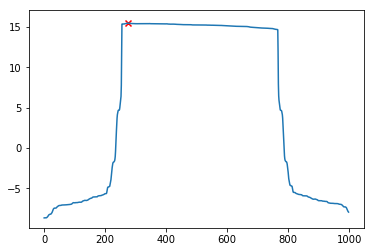

In [340]:
x = range(len(sdrs))
max_idx = sdrs.index(max(sdrs))
plt.plot(x,sdrs)
plt.scatter(max_idx,sdrs[max_idx], c='r', marker = 'x')

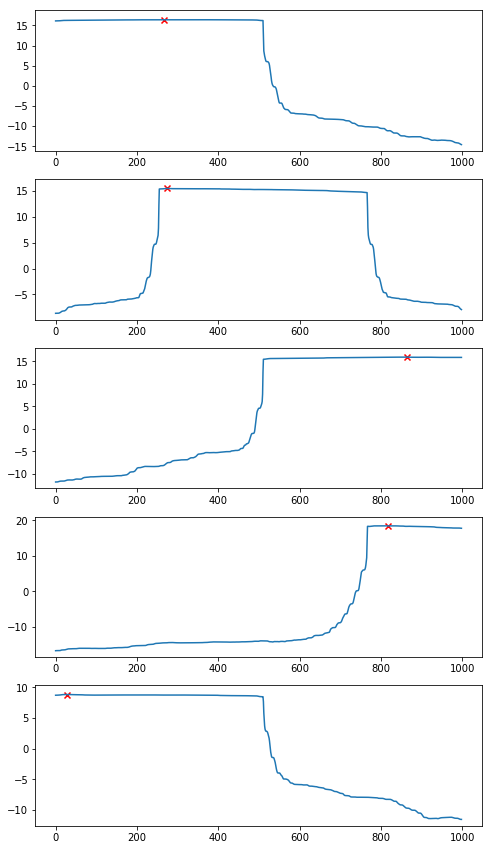

In [352]:
fig, ax = plt.subplots(5,1, figsize=(8,15))
for i in range(len(sdrs)):
    x = range(len(sdrs[i]))
    max_idx = sdrs[i].index(max(sdrs[i]))
    ax[i].plot(x,sdrs[i])
    ax[i].scatter(max_idx,sdrs[i][max_idx], c='r', marker = 'x')

In [51]:
import Utils
from functools import partial
import librosa
import importlib
importlib.reload(af)

<module 'Audio_functions' from 'C:\\Users\\Toby\\MSc_Project\\MScFinalProject\\Audio_functions.py'>

In [80]:
def get_paired_dataset(zipped_files,
                       sample_rate,
                       n_fft,
                       fft_hop,
                       patch_window,
                       patch_hop,
                       n_parallel_readers,
                       batch_size,
                       n_shuffle,
                       normalise):

    return (
        tf.data.Dataset.from_tensor_slices((zipped_files[:, 0], zipped_files[:, 1]))
        .map(partial(af.read_audio_pair,
                     sample_rate=sample_rate),
             num_parallel_calls=n_parallel_readers)
        .map(partial(af.extract_audio_patches_map,
                     fft_hop=fft_hop,
                     patch_window=patch_window,
                     patch_hop=patch_hop,),
             num_parallel_calls=n_parallel_readers)
        .flat_map(Utils.zip_tensor_slices)
        .map(partial(af.compute_spectrogram_map,
                     n_fft=n_fft,
                     fft_hop=fft_hop,
                     normalise=normalise),
             num_parallel_calls=n_parallel_readers)
        .shuffle(n_shuffle).batch(batch_size).prefetch(3)
    )

In [81]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=True
batch_size = 2
shuffle=False
n_shuffle = 1

checkpoint = '43/43-1001'
model_base_dir = 'C:/Users/Toby/MSc_Project/MScFinalProjectCheckpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

#directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Voice/train-clean-100/19/198/'

#  Create the pipeline
tf.reset_default_graph()
data = Dataset.zip_files(directory_a, directory_b)
data = get_paired_dataset(data,
                          sample_rate,
                          n_fft,
                          fft_hop,
                          patch_window,
                          patch_hop,
                          n_parallel_readers,
                          batch_size,
                          n_shuffle,
                          normalise)

In [82]:
data

<PrefetchDataset shapes: ((?, ?, 513, 2), (?, ?, 513, 2), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

In [83]:
#  Create the iterator
mixed_spec, voice_spec, mixed_audio, voice_audio = data.make_one_shot_iterator().get_next()

In [84]:
#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 0], 3)